In [4]:
import re
import torchtext
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm, trange
from torch.nn import Embedding
from torch.nn.functional import one_hot
import numpy as np
import itertools
import pickle
from sklearn import preprocessing
from matplotlib import pyplot as plt
from multiprocessing import Pool

In [137]:
a = pd.read_csv("nature_10.csv", sep='\t', names=['name', "journal", "issn", "doi", "volume", "issue", "year", "pages", "author(s)", "affiliations", "abstract", "references", "email"], header=None)

In [138]:
a

,name,journal,issn,doi,volume,issue,year,pages,author(s),affiliations,abstract,references,email
0,Chromatin remodeling regulated by steroid and ...,Cell Research,1748-7838,10.1038/cr.1997.14,7.0,2.0,1997.0,127-142,"Wolffe, Alan P","Wolffe, Alan P#:#Laboratory of Molecular Embro...",Coactivators and corepressors regulate transcr...,citation_journal_title=Ann Rev Genet; citation...,NaN
1,Biochemical detection of alien DNA incorporate...,Heredity,1365-2540,10.1038/hdy.1978.49,40.0,3.0,1978.0,439-455,"Flavell, Richard;O'Dell, Michael;Rimpau, Jürge...","Flavell, Richard#:#Department of Cytogenetics,...",Wheat lines carrying homologous pairs of compl...,"Barber, H N, Driscoll, C J, and Vickery, R S. ...",NaN
2,Early Archaean Age for the Isua Iron Formation...,Nature,1476-4687,10.1038/245138a0,245.0,5421.0,1973.0,138-139,"MOORBATH, S.;O'NIONS, R. K.;PANKHURST, R. J.","MOORBATH, S.#:#Department of Geology, Universi...","SOME 150 km north-east of Godthaab, on the edg...",citation_journal_title=Nature; citation_author...,NaN
3,Technical Education Abstracts,Nature,1476-4687,10.1038/193222a0,193.0,4812.0,1962.0,222-222,NaN,NaN,NaN,NaN,NaN
4,The Utility of Specific Characters,Nature,1476-4687,10.1038/054365b0,54.0,1399.0,1896.0,365-366,"LANKESTER, E. RAY","LANKESTER, E. RAY#:#Dinard, Bretagne",I REGRET very much that I did not correctly re...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"3,3-Difluoroallyl ammonium salts: highly versa...",Nature Communications,2041-1723,10.1038/s41467-021-23504-2,12.0,1.0,2021.0,1-9,"Ye, Fei;Ge, Yao;Spannenberg, Anke;Neumann, Hel...","Ye, Fei#:#Key Laboratory of Organosilicon Chem...",The selective synthesis of fluorinated organic...,citation_journal_title=Chem. Soc. Rev.; citati...,Matthias Beller#:#matthias.beller@catalysis.de
9996,Swedish Physics Conference of September 1952,Nature,1476-4687,10.1038/174863c0,174.0,4436.0,1954.0,863-863,NaN,NaN,NaN,NaN,NaN
9997,Apc modulates embryonic stem-cell differentiat...,Nature Genetics,1546-1718,10.1038/ng1045,32.0,4.0,2002.0,594-605,"Kielman, Menno F.;Rindapää, Maaret;Gaspar, Cla...","Kielman, Menno F.#:#Center for Human and Clini...",The Wnt signal-transduction pathway induces th...,citation_journal_title=Genes Dev.; citation_ti...,Riccardo Fodde#:#r.fodde@lumc.nl
9998,PCH1 and PCHL promote photomorphogenesis in pl...,Nature Communications,2041-1723,10.1038/s41467-017-02311-8,8.0,1.0,2017.0,1-9,"Enderle, Beatrix;Sheerin, David J.;Paik, Inyup...","Enderle, Beatrix#:#Faculty of Biology, Institu...",Phytochrome B (phyB) is the primary red light ...,citation_journal_title=Annu. Rev. Plant. Biol....,Andreas Hiltbrunner#:#andreas.hiltbrunner@biol...


In [140]:
a = a.drop(labels=['issn','volume', 'issue', 'year', 'pages', 'author(s)', 'affiliations', 'abstract' ,'email'], axis=1)

In [141]:
a

,name,journal,doi,references
0,Chromatin remodeling regulated by steroid and ...,Cell Research,10.1038/cr.1997.14,citation_journal_title=Ann Rev Genet; citation...
1,Biochemical detection of alien DNA incorporate...,Heredity,10.1038/hdy.1978.49,"Barber, H N, Driscoll, C J, and Vickery, R S. ..."
2,Early Archaean Age for the Isua Iron Formation...,Nature,10.1038/245138a0,citation_journal_title=Nature; citation_author...
3,Technical Education Abstracts,Nature,10.1038/193222a0,NaN
4,The Utility of Specific Characters,Nature,10.1038/054365b0,NaN
...,...,...,...,...
9995,"3,3-Difluoroallyl ammonium salts: highly versa...",Nature Communications,10.1038/s41467-021-23504-2,citation_journal_title=Chem. Soc. Rev.; citati...
9996,Swedish Physics Conference of September 1952,Nature,10.1038/174863c0,NaN
9997,Apc modulates embryonic stem-cell differentiat...,Nature Genetics,10.1038/ng1045,citation_journal_title=Genes Dev.; citation_ti...
9998,PCH1 and PCHL promote photomorphogenesis in pl...,Nature Communications,10.1038/s41467-017-02311-8,citation_journal_title=Annu. Rev. Plant. Biol....


In [142]:
p = re.compile("citation_doi=.+;|$")

In [143]:
a = a.dropna(subset=['references'])

In [144]:
a['references'] = a['references'].str.split('#;#').map(lambda x: list(filter(lambda z: z!="", list(map(lambda y: re.findall(p, y)[0], x)))))[a['references'].apply(len)>0]

/tmp/.private/exe/ipykernel_4200/1799010090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['references'] = a['references'].str.split('#;#').map(lambda x: list(filter(lambda z: z!="", list(map(lambda y: re.findall(p, y)[0], x)))))[a['references'].apply(len)>0]


In [145]:
a

,name,journal,doi,references
0,Chromatin remodeling regulated by steroid and ...,Cell Research,10.1038/cr.1997.14,[citation_doi=10.1146/annurev.ge.11.120177.001...
1,Biochemical detection of alien DNA incorporate...,Heredity,10.1038/hdy.1978.49,"[citation_doi=10.1139/g75-013;, citation_doi=1..."
2,Early Archaean Age for the Isua Iron Formation...,Nature,10.1038/245138a0,"[citation_doi=10.1098/rsta.1973.0014;, citatio..."
6,Placental Restriction Alters the Functional De...,Pediatric Research,10.1203/00006450-199612000-00014,"[citation_doi=10.1210/edrv-10-2-182;, citation..."
7,Deducing the coefficient of relationship by th...,Heredity,10.1038/hdy.1993.72,"[citation_doi=10.1080/00218839.1987.11100731;,..."
...,...,...,...,...
9993,South Asian agriculture increasingly dependent...,Nature Climate Change,10.1038/s41558-022-01355-z,[]
9995,"3,3-Difluoroallyl ammonium salts: highly versa...",Nature Communications,10.1038/s41467-021-23504-2,"[citation_doi=10.1039/b610738a;, citation_doi=..."
9997,Apc modulates embryonic stem-cell differentiat...,Nature Genetics,10.1038/ng1045,"[citation_doi=10.1101/gad.11.24.3286;, citatio..."
9998,PCH1 and PCHL promote photomorphogenesis in pl...,Nature Communications,10.1038/s41467-017-02311-8,[citation_doi=10.1146/annurev-arplant-050312-1...


In [146]:
a = a.dropna(subset=['references'])[a['references'].dropna().apply(len)!=0]

In [147]:
a

,name,journal,doi,references
0,Chromatin remodeling regulated by steroid and ...,Cell Research,10.1038/cr.1997.14,[citation_doi=10.1146/annurev.ge.11.120177.001...
1,Biochemical detection of alien DNA incorporate...,Heredity,10.1038/hdy.1978.49,"[citation_doi=10.1139/g75-013;, citation_doi=1..."
2,Early Archaean Age for the Isua Iron Formation...,Nature,10.1038/245138a0,"[citation_doi=10.1098/rsta.1973.0014;, citatio..."
6,Placental Restriction Alters the Functional De...,Pediatric Research,10.1203/00006450-199612000-00014,"[citation_doi=10.1210/edrv-10-2-182;, citation..."
7,Deducing the coefficient of relationship by th...,Heredity,10.1038/hdy.1993.72,"[citation_doi=10.1080/00218839.1987.11100731;,..."
...,...,...,...,...
9992,Cross-Over Concentration in Polydisperse Polym...,Polymer Journal,10.1295/polymj.19.1279,[citation_doi=10.1021/ma50004a042;]
9995,"3,3-Difluoroallyl ammonium salts: highly versa...",Nature Communications,10.1038/s41467-021-23504-2,"[citation_doi=10.1039/b610738a;, citation_doi=..."
9997,Apc modulates embryonic stem-cell differentiat...,Nature Genetics,10.1038/ng1045,"[citation_doi=10.1101/gad.11.24.3286;, citatio..."
9998,PCH1 and PCHL promote photomorphogenesis in pl...,Nature Communications,10.1038/s41467-017-02311-8,[citation_doi=10.1146/annurev-arplant-050312-1...


In [148]:
a['references'] = a['references'].map(lambda x: list(map(lambda y: y.replace(";", "").split("=")[1], x)))

In [149]:
a

,name,journal,doi,references
0,Chromatin remodeling regulated by steroid and ...,Cell Research,10.1038/cr.1997.14,"[10.1146/annurev.ge.11.120177.001323, 10.1021/..."
1,Biochemical detection of alien DNA incorporate...,Heredity,10.1038/hdy.1978.49,"[10.1139/g75-013, 10.1098/rstb.1976.0044, 10.1..."
2,Early Archaean Age for the Isua Iron Formation...,Nature,10.1038/245138a0,"[10.1098/rsta.1973.0014, 10.1016/0016-7037(70)..."
6,Placental Restriction Alters the Functional De...,Pediatric Research,10.1203/00006450-199612000-00014,"[10.1210/edrv-10-2-182, 10.1677/joe.0.1470139,..."
7,Deducing the coefficient of relationship by th...,Heredity,10.1038/hdy.1993.72,"[10.1080/00218839.1987.11100731, 10.1080/00015..."
...,...,...,...,...
9992,Cross-Over Concentration in Polydisperse Polym...,Polymer Journal,10.1295/polymj.19.1279,[10.1021/ma50004a042]
9995,"3,3-Difluoroallyl ammonium salts: highly versa...",Nature Communications,10.1038/s41467-021-23504-2,"[10.1039/b610738a, 10.1126/science.1131943, 10..."
9997,Apc modulates embryonic stem-cell differentiat...,Nature Genetics,10.1038/ng1045,"[10.1101/gad.11.24.3286, 10.1016/S0167-4889(99..."
9998,PCH1 and PCHL promote photomorphogenesis in pl...,Nature Communications,10.1038/s41467-017-02311-8,"[10.1146/annurev-arplant-050312-120221, 10.119..."


In [152]:
le = preprocessing.LabelEncoder()

In [153]:
voc = list(itertools.chain.from_iterable(list(a['references'])))

In [154]:
voc += list(a['doi'])
voc

['10.1146/annurev.ge.11.120177.001323',
 '10.1021/bi00560a004',
 '10.1016/S0021-9258(19)68221-9',
 '10.1021/bi00270a004',
 '10.1021/bi00271a012',
 '10.1016/S0021-9258(19)77625-X',
 '10.1093/emboj/16.23.7130',
 '10.1016/0092-8674(83)90335-5',
 '10.1093/nar/16.20.9663',
 '10.1126/science.2830672',
 '10.1002/j.1460-2075.1993.tb05674.x',
 '10.1101/gad.9.24.3051',
 '10.1093/nar/11.4.1151',
 '10.1111/j.1432-1033.1983.tb07162.x',
 '10.1073/pnas.85.19.7119',
 '10.1093/nar/20.17.4525',
 '10.1073/pnas.88.8.3125',
 '10.1126/science.8248805',
 '10.1042/bj2940557',
 '10.1016/S0021-9258(18)55252-2',
 '10.1074/jbc.272.17.11526',
 '10.1093/nar/22.10.1815',
 '10.1073/pnas.93.21.11540',
 '10.1016/0092-8674(84)90523-3',
 '10.1126/science.8178167',
 '10.1016/0968-0004(94)90148-1',
 '10.1126/science.1347958',
 '10.1016/S0022-2836(99)80015-1',
 '10.1002/j.1460-2075.1988.tb03172.x',
 '10.1002/j.1460-2075.1987.tb02507.x',
 '10.1101/gad.9.15.1933',
 '10.1021/bi00038a046',
 '10.1002/j.1460-2075.1992.tb05365.x',

In [155]:
len(set(voc))

196046

In [156]:
le.fit(voc)

LabelEncoder()

In [157]:
a['doi'] = le.transform(a['doi'])

In [158]:
with Pool(8) as p:
    a['references'] = list(p.map(le.transform, a['references']))

In [162]:
a['references']

0       [158645, 61982, 26188, 61907, 61909, 26193, 12...
1       [157355, 132164, 69391, 27526, 21480, 25475, 1...
2                          [132107, 21224, 20789, 132105]
6       [174002, 184929, 184922, 157439, 174213, 16574...
7         [115323, 115223, 12287, 103107, 103106, 115322]
                              ...                        
9992                                              [65357]
9995    [100559, 148895, 99505, 100578, 62804, 62805, ...
9997    [132942, 29617, 27914, 71690, 33197, 150243, 3...
9998    [157818, 172792, 27355, 81878, 86377, 102382, ...
9999                                              [13106]
Name: references, Length: 6716, dtype: object

In [163]:
a['journal'] = le.fit_transform(a['journal'])

In [164]:
max(a['journal'])

158

In [165]:
nothing = max(list(itertools.chain.from_iterable(list(a['references'])))) + 1

In [166]:
def vectorize(smth):
    if len(smth) < max(a['references'].map(len)):
        smth = torch.cat((torch.tensor(smth, dtype=torch.float), torch.zeros(max(a['references'].map(len)) - len(smth), dtype=torch.float) + nothing))
    else:
        smth = torch.tensor(smth, dtype=torch.float)
    return smth

In [167]:
a['references'] = a['references'].map(vectorize)

In [111]:
a

,name,journal,doi,references
0,Chromatin remodeling regulated by steroid and ...,16,74242,"[tensor(159366.), tensor(61983.), tensor(26188..."
1,Biochemical detection of alien DNA incorporate...,31,75084,"[tensor(158076.), tensor(132884.), tensor(6947..."
2,Early Archaean Age for the Isua Iron Formation...,53,69851,"[tensor(132827.), tensor(21224.), tensor(20789..."
6,Placental Restriction Alters the Functional De...,128,174448,"[tensor(174723.), tensor(185696.), tensor(1856..."
7,Deducing the coefficient of relationship by th...,31,75154,"[tensor(116043.), tensor(115943.), tensor(1228..."
...,...,...,...,...
9993,South Asian agriculture increasingly dependent...,64,92388,"[tensor(196814.), tensor(196814.), tensor(1968..."
9995,"3,3-Difluoroallyl ammonium salts: highly versa...",73,91925,"[tensor(101278.), tensor(149616.), tensor(1002..."
9997,Apc modulates embryonic stem-cell differentiat...,79,82998,"[tensor(133662.), tensor(29617.), tensor(27914..."
9998,PCH1 and PCHL promote photomorphogenesis in pl...,73,91172,"[tensor(158539.), tensor(173513.), tensor(2735..."


In [168]:
X_train, X_test, y_train, y_test = train_test_split(
    a['references'].reset_index(drop=True), a['journal'].reset_index(drop=True),
    test_size=0.2, random_state=1)

In [169]:
class JournalDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [170]:
train_dataset = JournalDataset(X_train.values, y_train.values)
test_dataset = JournalDataset(X_test.values, y_test.values)

In [171]:
train_loader = DataLoader(train_dataset, batch_size=128, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, drop_last=True)

In [280]:
model = nn.Sequential(nn.Linear(349, 159), 
                      nn.ReLU(),
                      nn.Linear(159, 159),
                      nn.ReLU(),
                      nn.Linear(159, 159))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [281]:
losses = []
n_epochs = 100
for epoch in range(n_epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.type(torch.long))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.type(torch.long)).item()
            acc = accuracy_score(y_batch, predictions.argmax(dim=1).cpu().detach()).item()
            val_loss += loss
            val_acc += acc
        losses.append(val_loss)

In [285]:
accuracies[-1]/

2.3046875

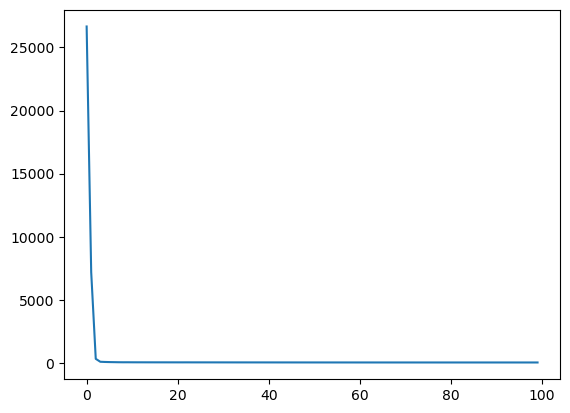

In [282]:
plt.plot(list(range(100)),losses)
plt.show()

In [176]:
class ConvNet(nn.Module): 
    def __init__(self): 
        super(ConvNet, self).__init__() 
        self.layer1 = nn.Sequential( nn.Conv1d(128, 128, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool1d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential( nn.Conv1d(128, 128, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool1d(kernel_size=2, stride=2)) 
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(87, 1000) 
        self.fc2 = nn.Linear(1000, 159)
    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
        #out = out.reshape(out.size(0), -1) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

In [194]:
model = ConvNet()

In [189]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [190]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(100):
    for i, (references, journals) in enumerate(train_loader):
        outputs = model(references)
        loss = criterion(outputs, journals)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

In [199]:
losses = []
accuracies = []
model = ConvNet()
n_epochs = 100
for epoch in range(n_epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.type(torch.long))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.type(torch.long)).item()
            acc = accuracy_score(y_batch, predictions.argmax(dim=1).cpu().detach()).item()
            val_loss += loss
            val_acc += acc
        losses.append(val_loss)
        accuracies.append(val_acc)

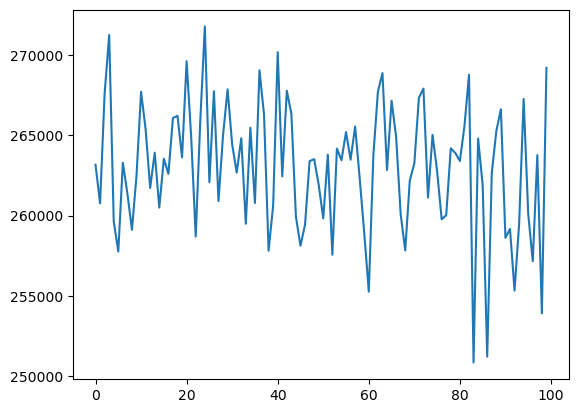

In [200]:
plt.plot(list(range(100)), losses)

In [192]:
loss_list[-1]

3.4956557750701904

In [313]:
losses = []
accuracies = []
n_epochs = 100
for epoch in range(n_epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        predictions = model1(X_batch)
        loss = criterion1(predictions, y_batch.type(torch.long))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader:
            predictions = model1(X_batch)
            loss = criterion1(predictions, y_batch.type(torch.long)).item()
            acc = accuracy_score(y_batch, predictions.argmax(dim=1).cpu().detach()).item()
            val_loss += loss
            val_acc += acc
        losses.append(val_loss)
        accuracies.append(val_acc)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    a['references'].reset_index(drop=True), nn.functional.one_hot(torch.tensor(np.array(a['journal'].reset_index(drop=True)), dtype=torch.int64)),
    test_size=0.2, random_state=1)

In [394]:
emb = nn.Embedding(len(set(voc))+1, 128)

In [395]:
embedded = a['references'].map(lambda x: emb(x.to(dtype=torch.int64)))

In [396]:
embedded[0].shape

torch.Size([349, 128])

In [69]:
class Dataset2d(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        self.emb = nn.Embedding(len(set(voc))+1, 158)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.emb(self.X[idx].to(dtype=torch.int64)), self.y[idx]

In [70]:
train_dataset2d = Dataset2d(X_train.values, y_train)
test_dataset2d = Dataset2d(X_test.values, y_test)

In [71]:
train_loader2d = DataLoader(train_dataset2d, batch_size=128, drop_last=True)
test_loader2d = DataLoader(test_dataset2d, batch_size=128, drop_last=True)

In [72]:
class ConvNet2d(nn.Module): 
    def __init__(self): 
        super(ConvNet2d, self).__init__() 
        self.layer1 = nn.Sequential( nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential( nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(39, 1000) 
        self.fc2 = nn.Linear(1000, 159)
    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = self.drop_out(out) 
        out = self.fc1(out) 
        out = self.fc2(out) 
        return out

In [202]:
losses = []
accuracies = []
n_epochs = 10
model2d = ConvNet2d()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2d.parameters(), lr=0.001)
for epoch in range(n_epochs):
    val_loss = 0
    for X_batch, y_batch in train_loader2d:
        predictions = model2d(X_batch)
        loss = criterion(predictions, y_batch.type(torch.long))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for X_batch, y_batch in test_loader2d:
            predictions = model2d(X_batch)
            loss = criterion(predictions, y_batch.type(torch.long)).item()
            val_loss += loss
        losses.append(val_loss)


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader2d:
        outputs = model2d(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

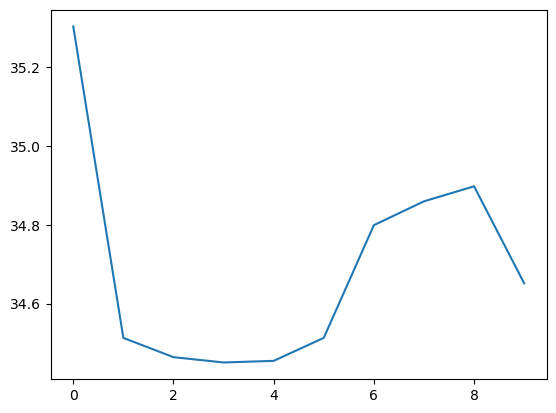

In [204]:
plt.plot(list(range(10)), losses)

In [91]:
loss

2.4716475009918213